In [1]:
import numpy as np
import nltk
import pyphen
from nltk import FreqDist
import string
import enchant

In [2]:
## Helper functions for dimensions of the embedding

# average sentences per paragraph
def words_per_sent(words, sents):
    return len(words) / len(sents)

# average words per paragraph
def words_per_paragraph(words, paragraphs):
    return len(words) / len(paragraphs)

# average sentences per paragraph
def sents_per_paragraph(sents, paragraphs):
    return len(sents) / len(paragraphs)

#average characters per paragraph
def chars_per_paragraph(words, paragraphs):
    n_chars = sum([len(w) for w in words])
    return n_chars / len(paragraphs)

# average characters per word
def chars_per_word(words):
    n_chars = sum([len(w) for w in words])
    return n_chars / len(words)

# average syllables per word
def sylls_per_word(words, sylls=None):
    # create syllables dict if not provided as arg
    if not sylls:
        dic = pyphen.Pyphen(lang='en')
        sylls = [len(dic.inserted(w).split('-')) for w in words]
    return sum(sylls) / len(words)

# ratio of words with more than 'length' chars
def long_word_ratio(words, length=6):
    long_words = [w for w in words if len(w) > 6]
    return len(long_words) / len(words)

# ratio of words with more than 'length' syllables
def long_syl_word_ratio(words, sylls=None, length = 2):
    # create syllables dict if not provided as arg
    if not sylls:
        dic = pyphen.Pyphen(lang='en')
        sylls = [len(dic.inserted(w).split('-')) for w in words]
    long_syl_words = [w for w, syl in zip(words, sylls) if syl > length]
    return len(long_syl_words) / len(words)

# returns average word frequency
def avg_word_freq(words, freqs):
    n_words = len(words)
    freq_ratios = [freq / n_words for freq in freqs.values()]
    return sum(freq_ratios) / n_words

# pecentage of hits in the given dictionary (assumed to be in pyenchant format)
def dict_hits(words, word_dict):
    return sum([int(word_dict.check(w)) for w in words]) / len(words)

In [3]:
# helper function to embed a text given its sentences, words, and paragrpahs
def embed_text(sents, words, paras, dims = 10, long_word = 6, long_syll = 2):
    # quick data cleaning for words
    words_no_punct = [w for w in words if w not in string.punctuation]
    words_cleaned = [w.lower() for w in words_no_punct]
    
    # init dictionaries
    dic = pyphen.Pyphen(lang='en')
    word_dict = enchant.Dict('en_US')
    
    # precompute syllable dictionary and frequency distribution
    sylls = [len(dic.inserted(w).split('-')) for w in words_cleaned]
    freqs = FreqDist(words_cleaned)
    
    embedding = np.zeros(dims)
    # insert dimensions into embedding
    embedding[0] = words_per_sent(words_cleaned, sents)
    embedding[1] = words_per_paragraph(words_cleaned, paras)
    embedding[2] = sents_per_paragraph(sents, paras)
    embedding[3] = chars_per_paragraph(words_cleaned, paras)
    embedding[4] = chars_per_word(words_cleaned)
    embedding[5] = sylls_per_word(words_cleaned, sylls)
    embedding[6] = long_word_ratio(words_cleaned, length = long_word)
    embedding[7] = long_syl_word_ratio(words, sylls, length = long_syll)
    embedding[8] = avg_word_freq(words, freqs)
    embedding[9] = dict_hits(words_no_punct, word_dict)
    
    return embedding

In [4]:
# helper function to embed an nltk corpus object
def embed_nltk_corpus(corpus):
    sents = corpus.sents
    words = corpus.words
    paras = corpus.paras
    return embed_text(sents, words, paras)

In [5]:
## Calculate embeddings for the Brown corpus
from nltk.corpus import brown

dims = 10
brown_embedding_matrix = np.zeros((len(brown.categories()), dims))

for idx, cat in enumerate(brown.categories()):
    print (idx, cat)
    sents = brown.sents(categories=cat)
    words = brown.words(categories=cat)
    paras = brown.paras(categories=cat)
    embedding = embed_text(sents, words, paras, dims)
    
    brown_embedding_matrix[idx] = embedding

0 adventure
1 belles_lettres
2 editorial
3 fiction
4 government
5 hobbies
6 humor
7 learned
8 lore
9 mystery
10 news
11 religion
12 reviews
13 romance
14 science_fiction


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# standardize embeddings
scaler = StandardScaler()
brown_standardized_embeddings = scaler.fit_transform(brown_embedding_matrix)

# reduce to 2D with TSNE
tsne_1 = TSNE(random_state=42, perplexity=2)
embeddings_2d_tsne = tsne_1.fit_transform(brown_standardized_embeddings)

# reduce to 2D with PCA
pca_1 = PCA(n_components=2)
embeddings_2d_pca = pca_1.fit_transform(brown_standardized_embeddings)

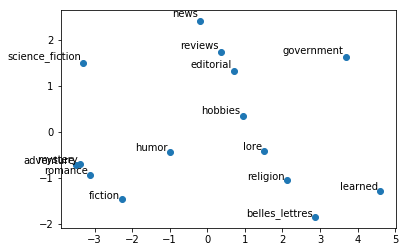

In [7]:
## Plot the PCA reduction of the Brown corpus embeddings
import matplotlib.pyplot as plt

plt.scatter(embeddings_2d_pca[:,0], embeddings_2d_pca[:,1])

for label, x, y in zip(brown.categories(), embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2, y),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

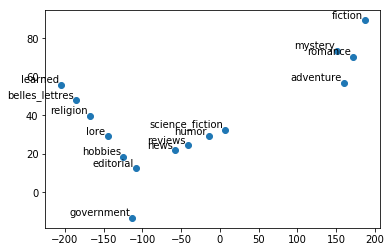

In [8]:
## Plot the TSNE reduction of the Brown corpus embeddings

plt.scatter(embeddings_2d_tsne[:,0], embeddings_2d_tsne[:,1])

for label, x, y in zip(brown.categories(), embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2,0),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

In [9]:
## Calculate embeddings for the Gutenberg corpus
from nltk.corpus import gutenberg

dims = 10
gutenberg_embedding_matrix = np.zeros((len(gutenberg.fileids()), dims))

for idx, file in enumerate(gutenberg.fileids()):
    print (idx, file)
    sents = gutenberg.sents(fileids=file)
    words = gutenberg.words(fileids=file)
    paras = gutenberg.paras(fileids=file)
    embedding = embed_text(sents, words, paras, dims)
    
    gutenberg_embedding_matrix[idx] = embedding

0 austen-emma.txt
1 austen-persuasion.txt
2 austen-sense.txt
3 bible-kjv.txt
4 blake-poems.txt
5 bryant-stories.txt
6 burgess-busterbrown.txt
7 carroll-alice.txt
8 chesterton-ball.txt
9 chesterton-brown.txt
10 chesterton-thursday.txt
11 edgeworth-parents.txt
12 melville-moby_dick.txt
13 milton-paradise.txt
14 shakespeare-caesar.txt
15 shakespeare-hamlet.txt
16 shakespeare-macbeth.txt
17 whitman-leaves.txt


In [10]:
# standardize embeddings
scaler = StandardScaler()
gutenberg_standardized_embeddings = scaler.fit_transform(gutenberg_embedding_matrix)

# reduce to 2D with TSNE
tsne_1 = TSNE(random_state=42, perplexity=2)
embeddings_2d_tsne = tsne_1.fit_transform(gutenberg_standardized_embeddings)

# reduce to 2D with PCA
pca_1 = PCA(n_components=2)
embeddings_2d_pca = pca_1.fit_transform(gutenberg_standardized_embeddings)

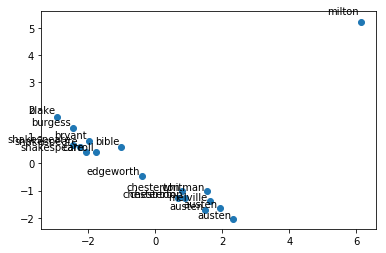

In [11]:
## Plot the PCA reduction of the Gutenberg corpus embeddings

plt.scatter(embeddings_2d_pca[:,0], embeddings_2d_pca[:,1])

for label, x, y in zip([f.split('-')[0] for f in gutenberg.fileids()], embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2, y),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

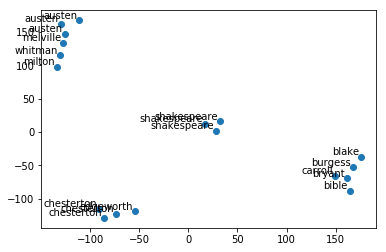

In [12]:
## Plot the PCA reduction of the Gutenberg corpus embeddings

plt.scatter(embeddings_2d_tsne[:,0], embeddings_2d_tsne[:,1])

for label, x, y in zip([f.split('-')[0] for f in gutenberg.fileids()], embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2,0),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

In [13]:
# helper label dictionaries for Brown corpus
label2idx = {f:idx for idx, f in enumerate(brown.categories())}
idx2label = {idx:f for idx, f in enumerate(brown.categories())}

In [14]:
from scipy.spatial.distance import cdist

# helper function to calculate n most similar vectors by cosine similarity
def n_most_similar(vec_idx, embeddings, n=3):
    # calculate cosine distance
    dists = cdist(embeddings[vec_idx,:].reshape(1, -1), embeddings)
    
    # get idx of n smallest dists
    idxs = np.argsort(dists.reshape(-1))[1:n+1]
    return idxs, dists.reshape(-1)[idxs]

# prints output from n_most_similar nicely
def print_n_most_similar(vec_idx, embeddings, idx2label, n=3):
    idxs, dists = n_most_similar(vec_idx, embeddings, n)
    label = idx2label[vec_idx]
    print(f"Most similar to {label}:")
    for i, out in enumerate(zip(idxs, dists)):
        l = idx2label[out[0]]
        print(f"   {i+1}. {l} -  Dist: {out[1]:.2f}")

In [15]:
print_n_most_similar(label2idx['adventure'], brown_standardized_embeddings, idx2label)

Most similar to adventure:
   1. romance -  Dist: 0.49
   2. mystery -  Dist: 0.61
   3. fiction -  Dist: 1.62


In [16]:
print_n_most_similar(label2idx['news'], brown_standardized_embeddings, idx2label)

Most similar to news:
   1. reviews -  Dist: 1.66
   2. editorial -  Dist: 2.01
   3. hobbies -  Dist: 2.75
